In [1]:
from numba import cuda, float32
import numba
import numpy as np
import math
import time
import cupy as cp

In [2]:
@numba.jit(nopython=True)
def matmul_cpu(A, B, C):
    for y in range(B.shape[1]):
        for x in range(A.shape[0]):
            tmp = 0.
            for k in range(A.shape[1]):
                tmp += A[x, k] * B[k, y]
            C[x, y] = tmp


@cuda.jit()
def matmul_gpu(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp


@cuda.jit()
def matmul_shared_mem(A, B, C):
    sA = cuda.shared.array((TPB, TPB), dtype=float32)
    sB = cuda.shared.array((TPB, TPB), dtype=float32)
    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    if x >= C.shape[0] and y >= C.shape[1]:
        return
    tmp = 0.
    for i in range(int(A.shape[1] / TPB)):
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]
        cuda.syncthreads()
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]
        cuda.syncthreads()
    C[x, y] = tmp


In [3]:
SIZE = 200
A_cpu = np.random.uniform(0, 1, size=(SIZE, SIZE))
B_cpu = np.random.uniform(0, 1, size=(SIZE, SIZE))
A_gpu = cp.asarray(A_cpu)
B_gpu = cp.asarray(B_cpu)
C_cpu = np.zeros((SIZE, SIZE), dtype=np.float32)
C_gpu = cp.zeros((SIZE, SIZE), dtype=np.float32)

**Произведение двух матриц на CPU**

In [4]:
%%time
matmul_cpu(A_cpu, B_cpu, C_cpu)

CPU times: user 535 ms, sys: 22.5 ms, total: 557 ms
Wall time: 930 ms


In [5]:
C_cpu

array([[44.916622, 49.941593, 48.623768, ..., 50.437267, 50.361526,
        48.809433],
       [48.301716, 52.09459 , 49.860134, ..., 51.739372, 52.010094,
        50.321735],
       [45.725243, 49.341755, 49.41554 , ..., 49.35939 , 52.26733 ,
        47.56921 ],
       ...,
       [43.6235  , 48.84848 , 43.440243, ..., 46.739456, 46.69271 ,
        44.725   ],
       [47.756752, 52.38956 , 50.84874 , ..., 54.454025, 55.534687,
        51.088886],
       [47.00979 , 53.283634, 47.81738 , ..., 52.284134, 52.284416,
        50.18201 ]], dtype=float32)

**Произведение двух матриц на GPU**

In [6]:
threads_per_block = (16, 16)  #Задаемся размерами блока. (20,20) - блок состоит из 400 потоков квадратом 20 на 20, обычно норма 128 - 512 threads/block
blockspergrid_x = int(np.ceil(C_gpu.shape[0] / threads_per_block[0])) #количество блоков по х
blockspergrid_y = int(np.ceil(C_gpu.shape[1] / threads_per_block[1]))
blocks_per_grid = (blockspergrid_x, blockspergrid_y)  # Создание сетки из блоков
print(blocks_per_grid) #Количество блоков в сетке
print(f"The kernel will be executed up to element {threads_per_block[0]*blockspergrid_x}") #Проверка размеров сетки для массива С

(13, 13)
The kernel will be executed up to element 208


In [7]:
%%time
matmul_gpu[blocks_per_grid, threads_per_block](A_gpu, B_gpu, C_gpu)

CPU times: user 279 ms, sys: 21 ms, total: 300 ms
Wall time: 614 ms


In [8]:
np.allclose(C_cpu, C_gpu)

array(True)

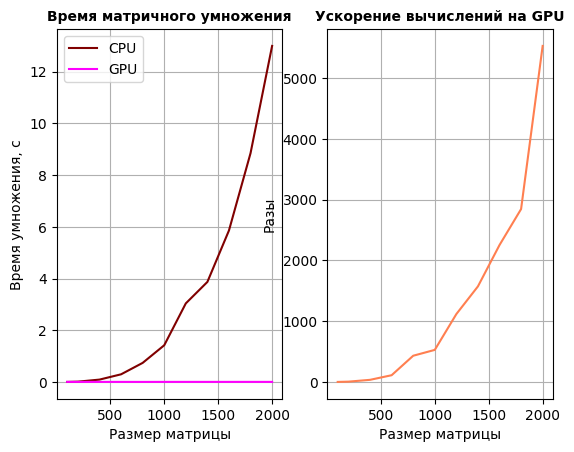

In [9]:
from matplotlib import pyplot as plt
size = [ 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000 ]
CPU_time = [ 0.00132, 0.0118, 0.0912, 0.296, 0.738, 1.42, 3.04, 3.87, 5.86, 8.85, 13 ]
GPU_time = [0.00257, 0.00236, 0.00261,  0.00267, 0.00171, 0.00269, 0.00272, 0.00246, 0.0026, 0.00311, 0.00235 ]

acceleration = [cpu / gpu for cpu, gpu in zip(CPU_time, GPU_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, CPU_time, label='CPU', color='maroon')
axes[0].plot(size, GPU_time, label='GPU', color='fuchsia')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Размер матрицы")
axes[0].set_ylabel("Время умножения, с")
axes[0].set_title('Время матричного умножения', font = {'weight':'bold', 'size': 10})

axes[1].plot(size, acceleration, color='coral')
axes[1].grid(True)
axes[1].set_xlabel("Размер матрицы")
axes[1].set_ylabel("Разы")
axes[1].set_title('Ускорение вычислений на GPU', font = {'weight':'bold', 'size': 10})

#plt.tight_layout()
plt.show()